0 22
Epoch  0 MSE:  0.04421490058302879
Epoch  1 MSE:  0.02742033079266548
Epoch  2 MSE:  0.03132869675755501
Epoch  3 MSE:  0.028463920578360558
Epoch  4 MSE:  0.025195851922035217
Epoch  5 MSE:  0.024283215403556824
Epoch  6 MSE:  0.024127310141921043
Epoch  7 MSE:  0.023155687376856804
Epoch  8 MSE:  0.020634999498724937
Epoch  9 MSE:  0.01657070964574814
Epoch  10 MSE:  0.013149751350283623
Epoch  11 MSE:  0.016635002568364143
Epoch  12 MSE:  0.006408534944057465
Epoch  13 MSE:  0.009909802116453648
Epoch  14 MSE:  0.012186978943645954
Epoch  15 MSE:  0.008433295413851738
Epoch  16 MSE:  0.0024372709449380636
Epoch  17 MSE:  0.004008489660918713
Epoch  18 MSE:  0.006804556120187044
Epoch  19 MSE:  0.002612169599160552
Epoch  20 MSE:  0.001595529611222446
Epoch  21 MSE:  0.0032879819627851248
Epoch  22 MSE:  0.00341708748601377
Epoch  23 MSE:  0.0030493789818137884
Epoch  24 MSE:  0.0029236702248454094
Epoch  25 MSE:  0.0029054824262857437
Epoch  26 MSE:  0.0026319304015487432
Epoch

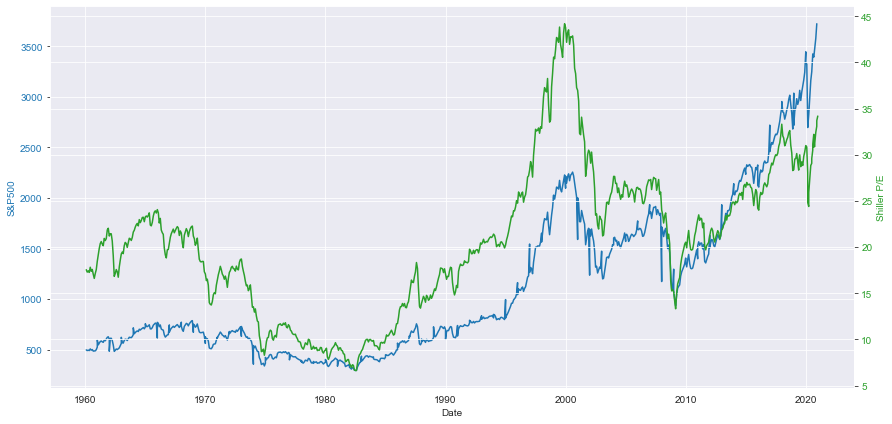

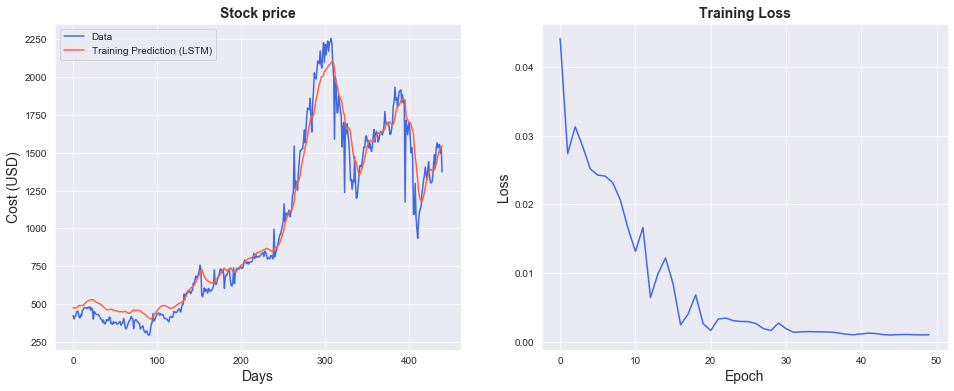

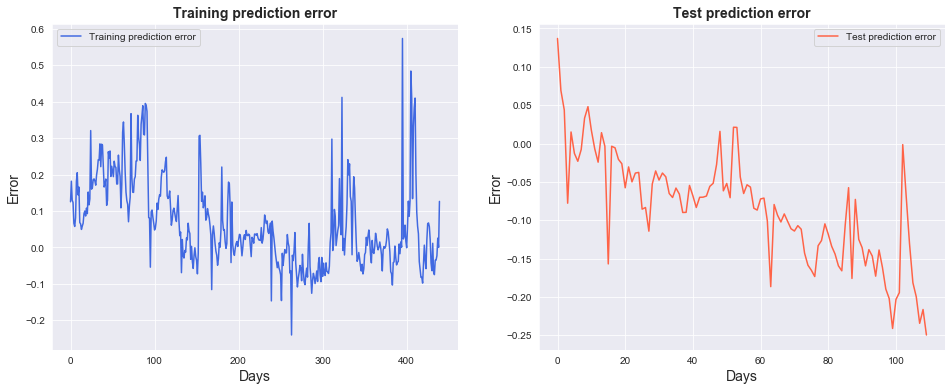

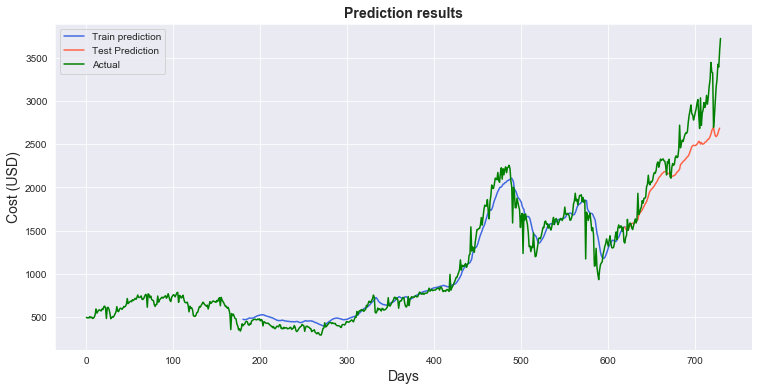

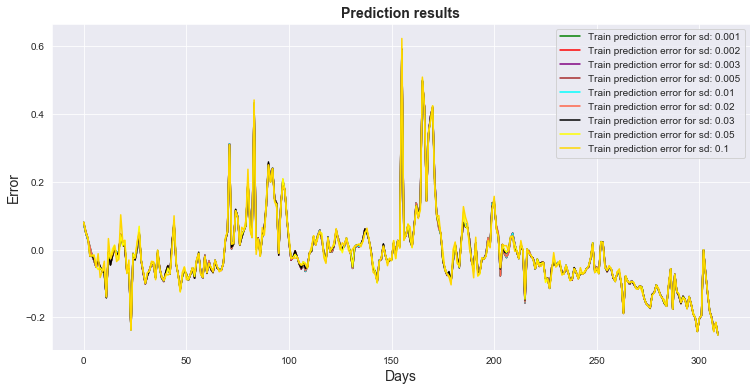

In [2]:
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
from dateutil import parser
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Noise is Gaussian with 10 percent cross-section
class GaussianNoiseTransform(object):
    def __init__(self, mean=0., std=1., k=25):
        self.std = std
        self.mean = mean
        self.k = k

    def __call__(self, tensor):

        for i, wnd in enumerate(tensor):
            # reshape and flatten
            x_transf = torch.flatten(wnd, start_dim=0)

            n = x_transf.size(0)
            perm = torch.randperm(n)
            idx = perm[:(n - self.k)]

            noise = torch.randn(x_transf.size())
            # only 10% is noise
            noise[idx] = 0.

            corrupted_image = x_transf + noise * self.std + self.mean

            tensor[i, :] = torch.unsqueeze(corrupted_image,1)

        return tensor

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class TrainingPipeline:

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, epochs):
        self.model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
        self.criterion = torch.nn.MSELoss(reduction='mean')
        self.optimiser = torch.optim.Adam(self.model.parameters(), lr=0.01)
        self.num_epochs = epochs
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def load_data(self, data_dir):
        # load shiller PE
        shiller = pd.read_csv(f'{data_dir}/shiller.csv', parse_dates=[0])
        # filter dates from: Jan 1, 1960 to Dec 31, 2020
        shiller = shiller[(shiller['Date'] > '1-1-1960') & (shiller['Date'] <= '12-31-2020')]
        shiller.sort_values(by='Date', inplace=True, ascending=True)

        # get index
        xls = pd.ExcelFile(f'{data_dir}/ie_data.xls')
        spx = pd.read_excel(xls, 'Data', converters={0: str})

        # Create column for Date
        spx['Date'] = None

        # set index
        index_set = 0
        index_date = spx.columns.get_loc('Date')
        print(index_set, index_date)

        # define pattern for date
        # in DD/MM/YYYY
        date_pattern = r'([0-9]{4}\.[0-9]{1,2})'

        # searching pattern
        # And storing in to DataFrame
        for row in range(0, len(spx)):
            m = spx.iat[row, index_set].split('.')
            spx.iat[row, index_date] = datetime.datetime(int(m[0]), int(m[1]), 1)

        spx = spx[(spx['Date'] > parser.parse('1-1-1960')) & (spx['Date'] <= parser.parse('12-31-2020'))]
        spx.sort_values(by='Date', inplace=True, ascending=True)

        return shiller, spx

    def normalize_price(self, spx):
        price = spx.iloc[:, 7].to_frame('Close')
        price['Close'] = self.scaler.fit_transform(price['Close'].values.reshape(-1, 1))

        return price

    def train_test_split(self, stock, wnd):
        data_raw = stock.to_numpy()  # convert to numpy array
        data = []

        # create all possible sequences of length seq_len
        for index in range(len(data_raw) - wnd):
            data.append(data_raw[index: index + wnd])

        data = np.array(data)
        # 20%-80% test-train split
        test_set_size = int(np.round(0.2 * data.shape[0]))
        train_set_size = data.shape[0] - (test_set_size)

        x_train = data[:train_set_size, :-1, :]
        y_train = data[:train_set_size, -1, :]

        x_test = data[train_set_size:, :-1]
        y_test = data[train_set_size:, -1, :]

        x_train = torch.from_numpy(x_train).type(torch.Tensor)
        x_test = torch.from_numpy(x_test).type(torch.Tensor)
        y_train = torch.from_numpy(y_train).type(torch.Tensor)
        y_test = torch.from_numpy(y_test).type(torch.Tensor)

        return [x_train, y_train, x_test, y_test]

    def get_test_data(self, spx, wnd, filter_date):
        spx = spx[spx['Date'] > parser.parse(filter_date)]

        price = self.normalize_price(spx)

        data_raw = price.to_numpy()

        data = []

        # create all possible sequences of length seq_len
        for index in range(len(data_raw) - wnd):
            data.append(data_raw[index: index + wnd])

        data = np.array(data)

        x_test = data[:, :-1]
        y_test = data[:, -1, :]

        x_test = torch.from_numpy(x_test).type(torch.Tensor)
        y_test = torch.from_numpy(y_test).type(torch.Tensor)

        return x_test, y_test, spx

    def train(self, x_train, y_train):
        hist = np.zeros(self.num_epochs)
        start_time = time.time()

        for t in range(self.num_epochs):
            y_train_pred = self.model(x_train)
            loss = self.criterion(y_train_pred, y_train)
            print("Epoch ", t, "MSE: ", loss.item())
            hist[t] = loss.item()
            self.optimiser.zero_grad()
            loss.backward()
            self.optimiser.step()

        training_time = time.time() - start_time
        print("Training time: {}".format(training_time))

        return y_train_pred, hist

    def inverse_transform_pair(self, y_train, y_train_original):
        predict = self.scaler.inverse_transform(y_train.detach().numpy())
        original = self.scaler.inverse_transform(y_train_original.detach().numpy())

        return predict, original

    def predict(self, x_test):
        # make predictions
        y_test_pred = self.model(x_test)

        return y_test_pred

    def compute_RMSE(self, x, y):
        return np.math.sqrt(mean_squared_error(x[:, 0], y[:, 0]))

    def compute_accuracy(self, y, x, sd=0.):
        return pd.DataFrame((y - x) / x, columns=[f'{sd}'])

    def collect(self, window, price, y_train_pred, y_test_pred):
        # shift train predictions for plotting
        trainPredictPlot = np.empty_like(price)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[window:len(y_train_pred) + window, :] = y_train_pred

        # shift test predictions for plotting
        testPredictPlot = np.empty_like(price)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[len(y_train_pred) + window - 1:len(price) - 1, :] = y_test_pred

        original = self.scaler.inverse_transform(price['Close'].values.reshape(-1, 1))

        predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
        predictions = np.append(predictions, original, axis=1)
        result = pd.DataFrame(predictions)

        return result

    def compute_noise_accuracy(self, sdevs, x_test, y_test, dt):

        result = pd.DataFrame(dt.head(len(x_test)))
        result.reset_index(drop=True, inplace=True)
        for sd in sdevs:
            noise = GaussianNoiseTransform(std=sd, k=18)
            x_test_noise = noise(x_test)

            # now predict on test data
            y_test_pred = self.predict(x_test_noise)
            y_test_pred, y = self.inverse_transform_pair(y_test_pred, y_test)

            # now calculate accuracy as (predicted_price-actual_price)/actual_price
            df = self.compute_accuracy(y_test_pred, y, sd)
            result = pd.concat([result, df], axis=1)

        return result

sns.set_style("darkgrid")

data_dir = "data"

# LSTM configurations
window = 180
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 50

pipeline = TrainingPipeline(input_dim, hidden_dim, output_dim, num_layers, num_epochs)
shiller, spx = pipeline.load_data(data_dir)

# graph them next to each other
fig, ax1 = plt.subplots(figsize=(12.5, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P500', color=color)
plt.plot(spx["Date"], spx.iloc[:, 7], color, label="Index")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Shiller P/E', color=color)  # we already handled the x-label with ax1
plt.plot(shiller["Date"], shiller["Value"], color, label="Shiller P/E")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# now normalize price
price = pipeline.normalize_price(spx)
# perform 20%-80% test train split on 180 sliding window
x_train, y_train, x_test, y_test = pipeline.train_test_split(price, window)

# train it
y_train_pred, hist = pipeline.train(x_train, y_train)

# plot the situation during training
y_train_pred, y_train = pipeline.inverse_transform_pair(y_train_pred, y_train)
predict, original = pd.DataFrame(y_train_pred), pd.DataFrame(y_train)

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x=original.index, y=original[0], label="Data", color='royalblue')
ax = sns.lineplot(x=predict.index, y=predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size=14, fontweight='bold')
ax.set_xlabel("Days", size=14)
ax.set_ylabel("Cost (USD)", size=14)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size=14)
ax.set_ylabel("Loss", size=14)
ax.set_title("Training Loss", size=14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()

# now predict on test data
y_test_pred = pipeline.predict(x_test)
y_test_pred, y_test = pipeline.inverse_transform_pair(y_test_pred, y_test)

# get RMSE
trainScore = pipeline.compute_RMSE(y_train, y_train_pred)
testScore = pipeline.compute_RMSE(y_test, y_test_pred)

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

# now calculate accuracy as (predicted_price-actual_price)/actual_price
trainAccuracy = pipeline.compute_accuracy(y_train_pred, y_train)
testAccuracy = pipeline.compute_accuracy(y_test_pred, y_test)

std_default = '0.0'
# graph accuracy
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x=trainAccuracy.index, y=trainAccuracy[std_default], label="Training prediction error", color='royalblue')
ax.set_title('Training prediction error', size=14, fontweight='bold')
ax.set_xlabel("Days", size=14)
ax.set_ylabel("Error", size=14)

plt.subplot(1, 2, 2)
ax = sns.lineplot(x=testAccuracy.index, y=testAccuracy[std_default], label="Test prediction error", color='tomato')
ax.set_xlabel("Days", size=14)
ax.set_ylabel("Error", size=14)
ax.set_title("Test prediction error", size=14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()

# collect predicted results
result = pipeline.collect(window, price, y_train_pred, y_test_pred)

plt.figure(figsize=(12.5, 6))
ax = sns.lineplot(x=result.index, y=result[0], label="Train prediction", color='royalblue')
ax = sns.lineplot(x=result.index, y=result[1], label="Test Prediction", color='tomato')
ax = sns.lineplot(x=result.index, y=result[2], label="Actual", color='green')
ax.set_title('Prediction results', size=14, fontweight='bold')
ax.set_xlabel("Days", size=14)
ax.set_ylabel("Cost (USD)", size=14)
plt.show()

# corrupt all test data with Gaussian noise
sdevs = [0., 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
# per instructions in step 4, test set is all data from Jan 1, 1980
filter_date = '1-1-1980'
x_test, y_test, filtered_spx = pipeline.get_test_data(spx, window, filter_date)
accuracy_df = pipeline.compute_noise_accuracy(sdevs, x_test, y_test, filtered_spx["Date"] )

# plot accuracies on same graph
colors = cycle(['blue', 'green', 'red', 'purple', 'brown', 'cyan', 'tomato', 'black', 'yellow','gold'])
plt.figure(figsize=(12.5, 6))
for col, c, sd in zip(accuracy_df, colors, sdevs):
    if col == "Date": continue
    ax = sns.lineplot(x=accuracy_df.index, y=accuracy_df[col], label=f"Train prediction error for sd: {sd}", color=c)
ax.set_title('Prediction results', size=14, fontweight='bold')
ax.set_xlabel("Days", size=14)
ax.set_ylabel("Error", size=14)
plt.show()

#write the accuracy table as CSV for step 6b
accuracy_df.to_csv(f'{data_dir}/noise_accuracy.csv', index=False)


